In [73]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import imghdr

In [66]:
import cv2

In [67]:
data_dir = "data"
image_extensions = ["jpeg", "jpg", "bmp", "png"] #List of allowed extensions

In [68]:
os.listdir(data_dir)

['Dogs', 'Cats']

In [ ]:
cv2.imread(os.path.join(data_dir, "Dogs", "1752573485303.jpeg")).shape
#height, width, no_clr_channels
#This is 46 pixels high 69 pixels wide

(46, 69, 3)

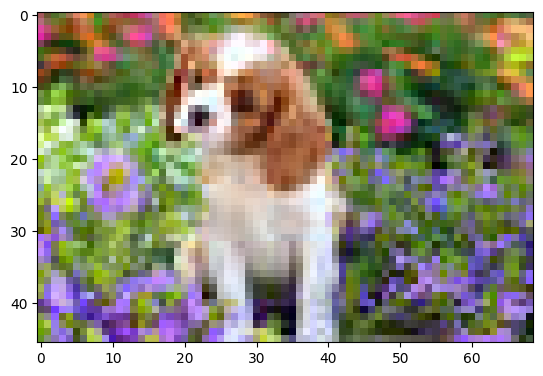

In [71]:
img = cv2.imread(os.path.join("data", "Dogs", "1752573485303.jpeg"))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#opencv uses bgr and matplotlib expects rgb so we are converting
plt.show()

In [74]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_extensions: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)



Image not in ext list data/Dogs/1752573485320.jpeg:Zone.Identifier
Image not in ext list data/Dogs/1752573485310.jpeg:Zone.Identifier
Image not in ext list data/Dogs/1752573485314.png:Zone.Identifier
Image not in ext list data/Dogs/1752573485318.jpeg:Zone.Identifier
Image not in ext list data/Dogs/1752573485315.jpeg:Zone.Identifier
Image not in ext list data/Dogs/1752573485304.jpeg:Zone.Identifier
Image not in ext list data/Dogs/1752573485314.jpeg:Zone.Identifier
Image not in ext list data/Dogs/1752573485311.jpeg:Zone.Identifier
Image not in ext list data/Dogs/1752573485333.jpeg:Zone.Identifier
Image not in ext list data/Dogs/24px.svg+xml
Image not in ext list data/Dogs/1752573485317.jpeg:Zone.Identifier
Image not in ext list data/Dogs/1752573485320.png:Zone.Identifier
Image not in ext list data/Dogs/1752573485311.gif
Image not in ext list data/Dogs/24px.svg+xml:Zone.Identifier
Image not in ext list data/Dogs/1752573485313.jpeg:Zone.Identifier
Image not in ext list data/Dogs/1752573485

Loading our data

In [75]:
data = tf.keras.utils.image_dataset_from_directory("data")
#Builds us the dataset and does some preprocessing

Found 54 files belonging to 2 classes.


In [76]:
#The data is a generator so we will convert it to a numpy iterator
data_iterator = data.as_numpy_iterator()
#We will get consecutive batches from .next()

In [77]:
batch = data_iterator.next()
batch

(array([[[[127.      , 192.      , 116.      ],
          [127.      , 192.      , 116.      ],
          [127.      , 192.      , 116.      ],
          ...,
          [127.      , 192.      , 116.      ],
          [127.      , 192.      , 116.      ],
          [127.      , 192.      , 116.      ]],
 
         [[127.      , 192.      , 116.      ],
          [127.      , 192.      , 116.      ],
          [127.      , 192.      , 116.      ],
          ...,
          [127.      , 192.      , 116.      ],
          [127.      , 192.      , 116.      ],
          [127.      , 192.      , 116.      ]],
 
         [[127.      , 192.      , 116.      ],
          [127.      , 192.      , 116.      ],
          [127.      , 192.      , 116.      ],
          ...,
          [127.      , 192.      , 116.      ],
          [127.      , 192.      , 116.      ],
          [127.      , 192.      , 116.      ]],
 
         ...,
 
         [[127.      , 192.      , 116.      ],
          [127.   

In [78]:
len(batch) #the images and the labels


2

In [79]:
batch[0].shape #We have to index the 0 as we want the shape of the images batch[1] wil refer to the labels

(32, 256, 256, 3)

In [80]:
batch[1]

array([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)

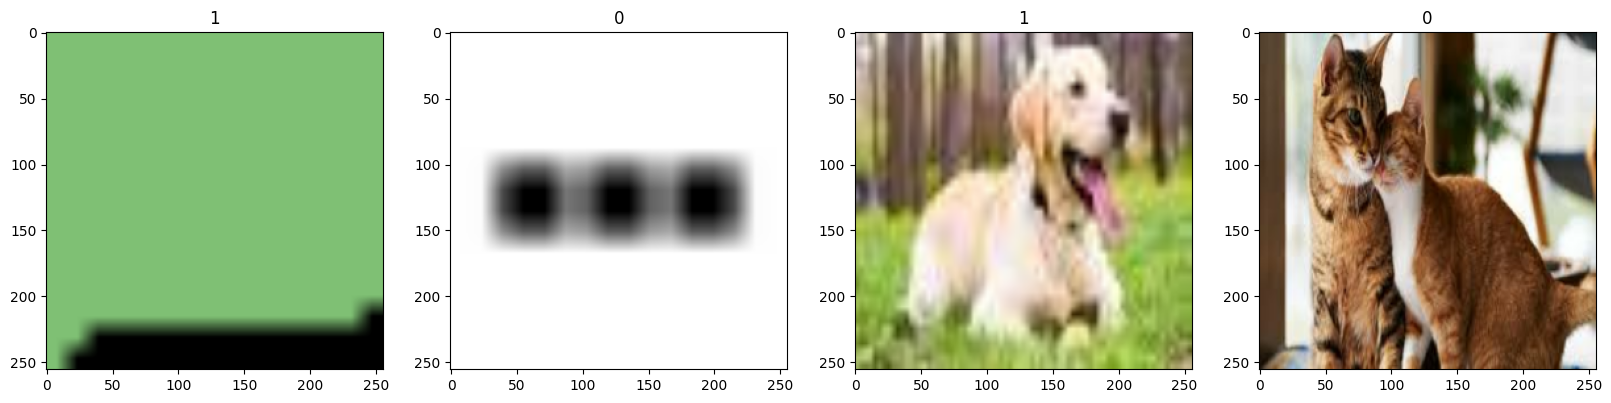

In [81]:
fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Preprocessing our data

In [82]:
data = data.map(lambda x,y: (x/255, y))
#Every time we fetch our data from the pipeline, it will scale our data between 0 and 1

In [83]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

In [85]:
batch[0].max()

np.float32(1.0)